# *- Introduccion  a la extraccion de datos de las empresas cotizantes de bolsa con la API de la SEC -*

### Paquetes

In [ ]:
import requests
import pandas as pd

### Vamos a crear una cabecera de la petición HTTP
> La SEC requiere un campo `User-Agent` con un correo de contacto.

In [ ]:
headers = {'User-agent': "correocualquiera@gmail.com"}

## Ahora vamos a descargar listado de compañías (CIK)

In [ ]:
companyTickers = requests.get(
    "https://www.sec.gov/files/company_tickers.json",
    headers=headers
)
print(companyTickers.json().keys())

dict_keys(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '40', '41', '42', '43', '44', '45', '46', '47', '48', '49', '50', '51', '52', '53', '54', '55', '56', '57', '58', '59', '60', '61', '62', '63', '64', '65', '66', '67', '68', '69', '70', '71', '72', '73', '74', '75', '76', '77', '78', '79', '80', '81', '82', '83', '84', '85', '86', '87', '88', '89', '90', '91', '92', '93', '94', '95', '96', '97', '98', '99', '100', '101', '102', '103', '104', '105', '106', '107', '108', '109', '110', '111', '112', '113', '114', '115', '116', '117', '118', '119', '120', '121', '122', '123', '124', '125', '126', '127', '128', '129', '130', '131', '132', '133', '134', '135', '136', '137', '138', '139', '140', '141', '142', '143', '144', '145', '146', '147', '148', '149', '150', '151', '152', '153', '154', '155', '156', 

# Tenemos que convertir el listado de compañías a DataFrame para trabajar con sus datos (*Nota como debemos llenar 10 caracteres la API de la SEC lo rquiere*)

In [ ]:
companyData = pd.DataFrame.from_dict(companyTickers.json(), orient='index')
companyData['cik_str'] = companyData['cik_str'].astype(str).str.zfill(10)
print(companyData.head(10))
cik = companyData.iloc[8].cik_str

      cik_str ticker                   title
0  0001045810   NVDA             NVIDIA CORP
1  0000789019   MSFT          MICROSOFT CORP
2  0000320193   AAPL              Apple Inc.
3  0001652044  GOOGL           Alphabet Inc.
4  0001018724   AMZN          AMAZON COM INC
5  0001326801   META    Meta Platforms, Inc.
6  0001730168   AVGO           Broadcom Inc.
7  0001318605   TSLA             Tesla, Inc.
8  0001067983  BRK-B  BERKSHIRE HATHAWAY INC
9  0000104169    WMT            Walmart Inc.


## Si queremos buscar el CIK de una empresa en especifico podemos usar su ticker para encontrar su CIK

In [ ]:
# Descargar archivo completo de tickers
resp = requests.get("https://www.sec.gov/files/company_tickers.json", headers=headers)
data = resp.json()

# Convertir a DataFrame para explorarlo
tickers_df = pd.DataFrame.from_dict(data, orient="index")
tickers_df[tickers_df["ticker"] == "NVO"]

,cik_str,ticker,title
54,353278,NVO,NOVO NORDISK A S


# Nos servira obtener los metadatos de los reportes de las empresas publicas e.g (K-10 filings)

In [ ]:
filingMetadata = requests.get(
    f'https://data.sec.gov/submissions/CIK{cik}.json',
    headers=headers
)
allForms = pd.DataFrame.from_dict(filingMetadata.json()['filings']['recent'])
allForms[['accessionNumber', 'reportDate', 'form']].head(100)

,accessionNumber,reportDate,form
0,0000950123-25-008361,2025-03-31,13F-HR/A
1,0000950170-25-108858,,SCHEDULE 13G
2,0000950170-25-108857,,SCHEDULE 13G/A
3,0000950123-25-008343,2025-06-30,13F-HR
4,0001728451-25-000006,2025-08-08,4
...,...,...,...
95,0000950170-24-113350,2024-10-03,4
96,0000950170-24-111799,2024-09-30,4
97,0001193125-24-229313,,424B5
98,0000950170-24-110123,2024-09-25,4


## Ahora obtendremos los datos de "Company Facts"
Estos datos incluye información como acciones en circulación y conceptos contables `us-gaap`.

In [ ]:
companyFacts = requests.get(
    f'https://data.sec.gov/api/xbrl/companyfacts/CIK{cik}.json',
    headers=headers
)
companyFacts.json()['facts'].keys()

dict_keys(['dei', 'us-gaap'])

##Ahora busquemos lo interesante a analizar los conceptos contables e.g (Assets)

In [ ]:
companyConcept = requests.get(
    f'https://data.sec.gov/api/xbrl/companyconcept/CIK{cik}/us-gaap/Assets.json',
    headers=headers
)
assetsData = pd.DataFrame.from_dict(companyConcept.json()['units']['USD'])
assets = assetsData[assetsData.form == '10-Q'].reset_index(drop=True)

#### Si por algun motivo necesitamos ver las llaves lo hacemos de esta manera

In [ ]:
companyFacts.json()['facts']['us-gaap'].keys()

dict_keys(['AccruedIncomeTaxesCurrent', 'AccumulatedOtherComprehensiveIncomeLossNetOfTax', 'AdditionalCollateralAggregateFairValue', 'AdditionalPaidInCapitalCommonStock', 'AdditionsToNoncurrentAssets', 'AdjustmentsNoncashItemsToReconcileNetIncomeLossToCashProvidedByUsedInOperatingActivitiesOther', 'AmortizationOfIntangibleAssets', 'Assets', 'AssetsHeldByInsuranceRegulators', 'AssumedPremiumsEarnedPropertyAndCasualty', 'AssumedPremiumsWrittenPropertyAndCasualty', 'AvailableForSaleDebtSecuritiesAccumulatedGrossUnrealizedGainBeforeTax', 'AvailableForSaleDebtSecuritiesAccumulatedGrossUnrealizedLossBeforeTax', 'AvailableForSaleDebtSecuritiesAmortizedCostBasis', 'AvailableForSaleEquitySecuritiesAccumulatedGrossUnrealizedGainBeforeTax', 'AvailableForSaleEquitySecuritiesAccumulatedGrossUnrealizedLossBeforeTax', 'AvailableForSaleEquitySecuritiesAmortizedCostBasis', 'AvailableForSaleSecuritiesDebtMaturitiesNextRollingTwelveMonthsAmortizedCostBasis', 'AvailableForSaleSecuritiesDebtMaturitiesNextR

## Grafiquemos la evolución de activos reportados en el formato 10-Q! (Este es de BRK-B)

<Axes: xlabel='end'>

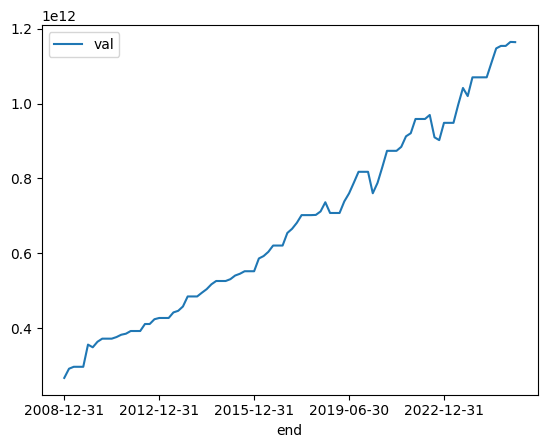

In [ ]:
assets.plot(x='end', y='val')

# ACTIVIDAD: Crear un sankey plot

In [ ]:
!pip install plotly --quiet

# Paquetes extras a usar


In [ ]:
import numpy as np
import plotly.graph_objects as go

# Creacion de la peticion

In [ ]:
HEADERS = {"User-Agent": "correocualquieras@gmail.com"}  # pon tu email

# JSON de la API

In [ ]:
# Descarga el índice de emisores
r = requests.get("https://www.sec.gov/files/company_tickers.json", headers=HEADERS)
df = pd.DataFrame.from_dict(r.json(), orient="index")
df["ticker"] = df["ticker"].str.upper()

# Busqueda del ticker o nombre de la empresa

In [ ]:
# Busca por ticker o por nombre
cand = df[(df["ticker"].isin(["BRK.A", "BRK.B"])) | (df["title"].str.contains("Berkshire Hathaway", case=False))]
if cand.empty:
    raise ValueError("No se encontró Berkshire en el índice de la SEC.")

cik_num = int(cand.iloc[0]["cik_str"])
cik_10d = str(cik_num).zfill(10)
cik_num, cik_10d, cand.iloc[0][["ticker","title"]].to_dict()

(1067983, '0001067983', {'ticker': 'BRK-B', 'title': 'BERKSHIRE HATHAWAY INC'})

# Seleccion del formato a estudiar

In [ ]:
subs = requests.get(f"https://data.sec.gov/submissions/CIK{cik_10d}.json", headers=HEADERS).json()
recent = pd.DataFrame.from_dict(subs["filings"]["recent"])

# Filtra 10-Q (y opcionalmente 10-Q/A)
q = recent[recent["form"].isin(["10-Q", "10-Q/A"])].copy()
if q.empty:
    raise ValueError("No hay 10-Q recientes para esta entidad.")
q = q[["filingDate","reportDate","form","accessionNumber","primaryDocument"]].sort_values("filingDate", ascending=False).reset_index(drop=True)
q.head(3)


,filingDate,reportDate,form,accessionNumber,primaryDocument
0,2025-08-04,2025-06-30,10-Q,0000950170-25-101578,brka-20250630.htm
1,2025-05-05,2025-03-31,10-Q,0000950170-25-063112,brka-20250331.htm
2,2024-11-04,2024-09-30,10-Q,0000950170-24-120241,brka-20240930.htm


# Peticion de los facts, seleccion de variables

In [ ]:
facts = requests.get(f"https://data.sec.gov/api/xbrl/companyfacts/CIK{cik_10d}.json", headers=HEADERS).json().get("facts", {})

# Elegimos el estandar contable preferente
taxonomy = "us-gaap" if "us-gaap" in facts else ("ifrs-full" if "ifrs-full" in facts else None)
if taxonomy is None:
    raise ValueError(f"No hay us-gaap/ifrs-full. Claves disponibles: {list(facts.keys())}")

def series_10q(concept, units="USD"):
    """Devuelve DataFrame de un concepto (solo 10-Q) con fechas y valores."""
    try:
        raw = facts[taxonomy][concept]["units"][units]
    except KeyError:
        return pd.DataFrame(columns=["end","val","form"])
    s = pd.DataFrame(raw)
    # Filtra solo formularios 10-Q
    if "form" in s.columns:
        s = s[s["form"].isin(["10-Q","10-Q/A"])].copy()
    # Asegura tipos
    for c in ["end","fy","fp","val"]:
        if c in s.columns:
            s[c] = s[c]
    # Ordena por fecha de fin de periodo
    if "end" in s.columns:
        s = s.sort_values("end", ascending=False)
    return s

# Mapa de conceptos posibles
C = dict(
    revenues=["Revenues", "SalesRevenueNet", "RevenueFromContractWithCustomerExcludingAssessedTax", "TotalRevenuesAndOtherIncome"],
    cost_rev=["CostOfRevenue", "CostOfGoodsAndServicesSold"],
    gp=["GrossProfit"],  # si falta, lo calculamos
    opex=["OperatingExpenses", "CostsAndExpenses"],
    sm=["SellingAndMarketingExpense"],
    rd=["ResearchAndDevelopmentExpense"],
    ga=["GeneralAndAdministrativeExpense"],
    op_inc=["OperatingIncomeLoss"],
    tax=["IncomeTaxExpenseBenefit"],
    net_inc=["NetIncomeLoss"]
)

def first_available(concepts):
    for c in concepts:
        s = series_10q(c)
        if not s.empty:
            return c, s
    return None, pd.DataFrame()

# Trae cada rubro (el más reciente)
sel = {}
for key, candidates in C.items():
    concept, dfc = first_available(candidates if isinstance(candidates, list) else [candidates])
    sel[key] = (concept, dfc)

sel

{'revenues': ('Revenues',
            start         end           val                  accn    fy  fp  \
  295  2025-04-01  2025-06-30   92515000000  0000950170-25-101578  2025  Q2   
  294  2025-01-01  2025-06-30  182240000000  0000950170-25-101578  2025  Q2   
  293  2025-01-01  2025-03-31   89725000000  0000950170-25-063112  2025  Q1   
  291  2024-07-01  2024-09-30   92995000000  0000950170-24-120241  2024  Q3   
  290  2024-01-01  2024-09-30  276517000000  0000950170-24-120241  2024  Q3   
  ..          ...         ...           ...                   ...   ...  ..   
  8    2009-04-01  2009-06-30   29607000000  0001157523-10-004882  2010  Q2   
  7    2009-01-01  2009-06-30   52391000000  0001157523-10-004882  2010  Q2   
  5    2009-01-01  2009-03-31   22784000000  0001157523-10-002982  2010  Q1   
  2    2008-07-01  2008-09-30   27926000000  0001157523-09-007839  2009  Q3   
  1    2008-01-01  2008-09-30   83194000000  0001157523-09-007839  2009  Q3   
  
       form       filed

# Paso 6

In [ ]:
def latest_val(key):
    concept, dfc = sel[key]
    if concept is None or dfc.empty:
        return None
    # último por fecha de cierre
    return float(dfc.iloc[0]["val"])

rev = latest_val("revenues")
cost = latest_val("cost_rev")
gp   = latest_val("gp")      # si None, calculamos
opex = latest_val("opex")
sm   = latest_val("sm")
rd   = latest_val("rd")
ga   = latest_val("ga")
op   = latest_val("op_inc")  # si None, calculamos
taxv = latest_val("tax")
net  = latest_val("net_inc")

# Backfills
if gp is None and (rev is not None and cost is not None):
    gp = rev - cost
if op is None:
    if gp is not None and opex is not None:
        op = gp - opex
    elif net is not None and taxv is not None:
        op = net + taxv  # aprox si no hay otros "otros" significativos

# “Otros” = puente entre utilidad operativa y neta (por simplicidad)
other = None
if op is not None and net is not None and taxv is not None:
    other = op - taxv - net

summary = {
    "Revenue": rev,
    "Cost of revenue": cost,
    "Gross profit": gp,
    "Operating expenses": opex,
    "S&M": sm,
    "R&D": rd,
    "G&A": ga,
    "Operating profit": op,
    "Tax": taxv,
    "Other": other,
    "Net profit": net
}
pd.Series(summary).dropna().round(2)

,0
Revenue,9.251500e+10
Operating expenses,7.938400e+10
Operating profit,5.885000e+09
Tax,2.293000e+09
Other,-8.778000e+09
Net profit,1.237000e+10


In [ ]:
# Construimos nodos y enlaces solo con los valores disponibles
labels = ["Revenue","Cost of revenue","Gross profit","Operating expenses","S&M","R&D","G&A","Operating profit","Tax","Other","Net profit"]
idx = {name:i for i,name in enumerate(labels)}

links = []
def add_link(src, dst, val):
    if val is None or val <= 0:
        return
    links.append(dict(source=idx[src], target=idx[dst], value=val))

# Flujo principal
add_link("Revenue","Cost of revenue", summary["Cost of revenue"])
if summary["Gross profit"] is not None:
    add_link("Revenue","Gross profit", summary["Gross profit"])  # visual: ingreso que “fluye” a GP

# Desglose OPEX si existe, si no, un bloque único
if summary["Operating expenses"] and not any([summary["S&M"], summary["R&D"], summary["G&A"]]):
    add_link("Gross profit","Operating expenses", summary["Operating expenses"])
else:
    if summary["S&M"]: add_link("Gross profit","S&M", summary["S&M"])
    if summary["R&D"]: add_link("Gross profit","R&D", summary["R&D"])
    if summary["G&A"]: add_link("Gross profit","G&A", summary["G&A"])

# Hacia utilidad operativa
if summary["Operating profit"]:
    # resta “implícita” = GP - (componentes)
    add_link("Gross profit","Operating profit", summary["Operating profit"])

# Impuestos y otros
if summary["Tax"]:   add_link("Operating profit","Tax", summary["Tax"])
if summary["Other"] and summary["Other"]>0: add_link("Operating profit","Other", summary["Other"])

# Utilidad neta
if summary["Net profit"]: add_link("Operating profit","Net profit", summary["Net profit"])

fig = go.Figure(data=[go.Sankey(
    arrangement="snap",
    node=dict(label=labels, pad=10, thickness=18),
    link=dict(source=[l["source"] for l in links],
              target=[l["target"] for l in links],
              value=[l["value"] for l in links])
)])
fig.update_layout(title="Berkshire Hathaway – 10‑Q Estado de Resultados 2025-06", font_size=12)
fig.show()